# **AutoEncoders Anomaly Detection in BlockChain DATASET**

System Specs

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Nov  5 09:41:01 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


Connect Gdrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import Necessary Modules

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import gc
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve, precision_recall_curve,
    balanced_accuracy_score, classification_report
)
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

Load Data

In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/BlockChainAnomaly/Data/DG_out.csv', encoding='utf-8')
print(df.head())


                                             tx_hash  indegree  outdegree  \
0  0437cd7f8525ceed2324359c2d0ba26006d92d856a9c20...         0          1   
1  f4184fc596403b9d638783cf57adfe4c75c605f6356fbc...         1          2   
2  ea44e97271691990157559d0bdd9959e02790c34db6c00...         1          1   
3  a16f3ce4dd5deb92d98ef5cf8afeaf0775ebca408f708b...         1          1   
4  591e91f809d716912ca1d4a9295e70c3e78bab077683f7...         1          2   

   in_btc  out_btc  total_btc  mean_in_btc  mean_out_btc  in_malicious  \
0     0.0     50.0       50.0          0.0          50.0             0   
1    50.0     50.0      100.0         50.0          25.0             0   
2    10.0     10.0       20.0         10.0          10.0             0   
3    40.0     30.0       70.0         40.0          30.0             0   
4    30.0     30.0       60.0         30.0          15.0             0   

   out_malicious  is_malicious  out_and_tx_malicious  all_malicious  
0              0      

In [ ]:
df.drop(['tx_hash', 'in_malicious', 'out_malicious', 'is_malicious', 'all_malicious'], axis=1, inplace=True)
df.columns

Index(['indegree', 'outdegree', 'in_btc', 'out_btc', 'total_btc',
       'mean_in_btc', 'mean_out_btc', 'out_and_tx_malicious'],
      dtype='object')

In [ ]:
df.describe()

,indegree,outdegree,in_btc,out_btc,total_btc,mean_in_btc,mean_out_btc,out_and_tx_malicious
count,3.024813e+07,3.024813e+07,3.024813e+07,3.024813e+07,3.024813e+07,3.024813e+07,3.024813e+07,3.024813e+07
mean,2.148699e+00,2.148699e+00,5.484150e+01,5.484150e+01,1.096830e+02,4.923980e+01,2.877087e+01,3.570468e-06
std,7.421447e+00,4.512048e+00,1.303303e+03,1.301473e+03,2.602527e+03,9.729210e+02,7.125567e+02,1.889565e-03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,2.000000e+00,1.000000e-01,9.950000e-02,2.058720e-01,6.400000e-02,5.025776e-02,0.000000e+00
50%,1.000000e+00,2.000000e+00,9.325000e-01,9.590000e-01,1.964759e+00,5.350261e-01,4.900000e-01,0.000000e+00
75%,2.000000e+00,2.000000e+00,8.591912e+00,9.063657e+00,1.840000e+01,5.614287e+00,4.519481e+00,0.000000e+00
max,1.932000e+03,1.322000e+03,5.500000e+05,5.000207e+05,1.050000e+06,4.992596e+05,5.000000e+05,1.000000e+00


No Frauds 99.99964 % of the dataset
Frauds 0.00036 % of the dataset


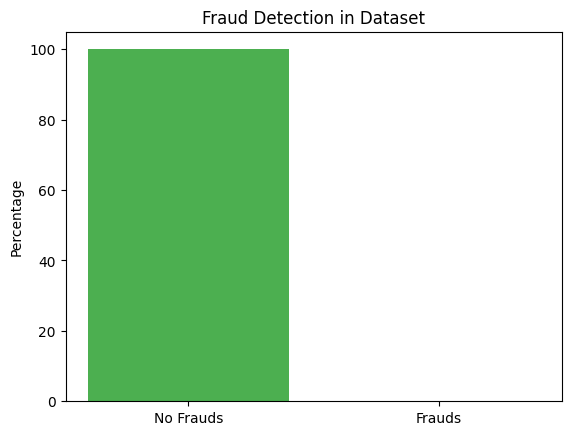

In [ ]:
fraud_counts = df['out_and_tx_malicious'].value_counts().tolist()
labels = ['No Frauds', 'Frauds']
total = len(df)
percentages = [count / total * 100 for count in fraud_counts]
print('No Frauds', round(percentages[0], 5), '% of the dataset')
print('Frauds', round(percentages[1], 5), '% of the dataset')

fig, ax = plt.subplots()
ax.bar(labels, percentages, color=['#4CAF50', '#F44336'])
ax.set_title('Fraud Detection in Dataset')
ax.set_ylabel('Percentage')
plt.show()

Feature Scaling using Log Transformation and RobustScaler

In [ ]:
df['indegree'] = np.log1p(df['indegree'])
df['outdegree'] = np.log1p(df['outdegree'])
df['in_btc'] = np.log1p(df['in_btc'])
df['out_btc'] = np.log1p(df['out_btc'])
df['total_btc'] = np.log1p(df['total_btc'])
df['mean_in_btc'] = np.log1p(df['mean_in_btc'])
df['mean_out_btc'] = np.log1p(df['mean_out_btc'])

In [ ]:
scaler = RobustScaler()
df['indegree'] = scaler.fit_transform(df['indegree'].values.reshape(-1, 1))
df['outdegree'] = scaler.fit_transform(df['outdegree'].values.reshape(-1, 1))
df['in_btc'] = scaler.fit_transform(df['in_btc'].values.reshape(-1, 1))
df['out_btc'] = scaler.fit_transform(df['out_btc'].values.reshape(-1, 1))
df['total_btc'] = scaler.fit_transform(df['total_btc'].values.reshape(-1, 1))
df['mean_in_btc'] = scaler.fit_transform(df['mean_in_btc'].values.reshape(-1, 1))
df['mean_out_btc'] = scaler.fit_transform(df['mean_out_btc'].values.reshape(-1, 1))

Split data into training and testing sets

In [ ]:
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(df.iloc[:, :-1], df['out_and_tx_malicious'], test_size=0.20, random_state=10)

In [ ]:
del df #save memory
gc.collect()

20

Data balancing

In [ ]:
train_full_df = pd.concat([X_train_full, y_train_full], axis=1)
train_normal_df = train_full_df[train_full_df.out_and_tx_malicious == 0]
train_fraud_df = train_full_df[train_full_df.out_and_tx_malicious == 1]

In [ ]:
test_full_df = pd.concat([X_test_full, y_test_full], axis=1)
test_normal_df = test_full_df[test_full_df.out_and_tx_malicious == 0]
test_fraud_df = test_full_df[test_full_df.out_and_tx_malicious == 1]

Helper Functions

In [ ]:
def sample_training_data(n):
    normal_sample = train_normal_df.sample(n)
    final_sample = pd.concat([normal_sample, train_fraud_df])
    return shuffle(final_sample.iloc[:, :-1].values), shuffle(final_sample.iloc[:, -1].values)

In [ ]:
def sample_test_data(n):
    normal_sample = test_normal_df.sample(n)
    final_sample = pd.concat([normal_sample, test_fraud_df])
    return shuffle(final_sample.iloc[:, :-1].values), shuffle(final_sample.iloc[:, -1].values)

In [ ]:
def oversample_minority(X, y, ratio):
    sm = SMOTE(sampling_strategy=ratio, n_jobs=-1)
    return sm.fit_resample(X, y)

In [ ]:
def evaluate_performance(actual, predicted, prob_scores, time_elapsed):
    metrics = {}
    metrics['time'] = time_elapsed
    metrics['conf_matrix'] = confusion_matrix(actual, predicted)

    metrics['balanced_accuracy'] = round(balanced_accuracy_score(actual, predicted), 7)
    metrics['accuracy'] = round(accuracy_score(actual, predicted), 7)

    metrics['macro_precision'] = round(precision_score(actual, predicted, average="macro"), 7)
    metrics['macro_recall'] = round(recall_score(actual, predicted, average="macro"), 7)
    metrics['macro_f1'] = round(f1_score(actual, predicted, average="macro"), 7)
    metrics['macro_roc'] = round(roc_auc_score(actual, prob_scores, average="macro"), 7)

    metrics['precision'] = round(precision_score(actual, predicted), 7)
    metrics['recall'] = round(recall_score(actual, predicted), 7)
    metrics['f1'] = round(f1_score(actual, predicted), 7)
    metrics['roc'] = round(roc_auc_score(actual, prob_scores), 7)

    fpr, tpr, thresholds = roc_curve(actual, prob_scores)
    metrics['false_pos_rate'] = fpr
    metrics['true_pos_rate'] = tpr
    metrics['thresholds'] = thresholds

    precision_rt, recall_rt, threshold_rt = precision_recall_curve(actual, prob_scores)
    metrics['precision_rt'] = precision_rt
    metrics['recall_rt'] = recall_rt
    metrics['threshold_rt'] = threshold_rt

    return metrics

Autoencoder Model Definition

In [ ]:
class AutoEncoderModel(nn.Module):
    def __init__(self, input_dim, hidden_neurons=[6, 4, 4, 6]):
        super(AutoEncoderModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_neurons[0]),
            nn.Tanh(),
            nn.Dropout(0.1),
            nn.Linear(hidden_neurons[0], hidden_neurons[1]),
            nn.Tanh(),
            nn.Dropout(0.1)
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_neurons[1], hidden_neurons[2]),
            nn.Tanh(),
            nn.Dropout(0.1),
            nn.Linear(hidden_neurons[2], hidden_neurons[3]),
            nn.Tanh(),
            nn.Dropout(0.1),
            nn.Linear(hidden_neurons[3], input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

Training

In [ ]:
training_results = {}
testing_results = {}
model_dict = {}

epochs = 100
batch_size = 256
contamination_ratio = 0.08169

In [ ]:
X_train_resampled, y_train_resampled = oversample_minority(X_train_full, y_train_full, contamination_ratio)

/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [ ]:
autoencoder = AutoEncoderModel(input_dim=X_train_resampled.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

In [ ]:
start_time = time.time()

for epoch in range(epochs):
    autoencoder.train()
    optimizer.zero_grad()

    #convert to numpy array, then to torch tensor, and move to GPU
    inputs = torch.tensor(X_train_resampled.values, dtype=torch.float32).to(device)
    outputs = autoencoder(inputs)

    loss = criterion(outputs, inputs)
    loss.backward()
    optimizer.step()

end_time = time.time()
training_duration = round(end_time - start_time, 4)

print(f"Training time: {training_duration} seconds")


Training time: 84.6043 seconds


Save Trained Model

In [ ]:
model_save_path = "/content/drive/MyDrive/BlockChainAnomaly/autoencoder.pth"
torch.save(autoencoder.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to /content/drive/MyDrive/BlockChainAnomaly/autoencoder.pth


Model Evaluation

In [ ]:
model_path = "/content/drive/MyDrive/BlockChainAnomaly/autoencoder.pth"

In [ ]:
#load the saved model
autoencoder = AutoEncoderModel(input_dim=X_train_resampled.shape[1])
autoencoder.load_state_dict(torch.load(model_path))
autoencoder.to(device)

<ipython-input-31-f6736ba3702c>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load(model_path))


AutoEncoderModel(
  (encoder): Sequential(
    (0): Linear(in_features=7, out_features=6, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=6, out_features=4, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.1, inplace=False)
  )
  (decoder): Sequential(
    (0): Linear(in_features=4, out_features=4, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=4, out_features=6, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=6, out_features=7, bias=True)
    (7): Sigmoid()
  )
)

In [ ]:
autoencoder.eval()
with torch.no_grad():
    # Convert DataFrame to numpy array, then to torch tensor, and move to GPU
    train_inputs = torch.tensor(X_train_resampled.values, dtype=torch.float32).to(device)
    train_outputs = autoencoder(train_inputs)
    reconstruction_errors = nn.MSELoss(reduction='none')(train_outputs, train_inputs).mean(dim=1).cpu().numpy()

In [ ]:
train_predictions = (reconstruction_errors > np.percentile(reconstruction_errors, (1-contamination_ratio) * 100)).astype(int)
training_results[1] = evaluate_performance(y_train_resampled, train_predictions, reconstruction_errors, training_duration)

In [ ]:
model_dict[1] = autoencoder

Model evaluation on test data


In [ ]:
autoencoder.eval()
with torch.no_grad():
    # Convert DataFrame to numpy array, then to torch tensor, and move to GPU
    test_inputs = torch.tensor(X_test_full.values, dtype=torch.float32).to(device)
    test_outputs = autoencoder(test_inputs)

    # Calculate reconstruction errors and move them back to CPU
    test_reconstruction_errors = nn.MSELoss(reduction='none')(test_outputs, test_inputs).mean(dim=1).cpu().numpy()

In [ ]:
test_predictions = (test_reconstruction_errors > np.percentile(test_reconstruction_errors, (1-contamination_ratio) * 100)).astype(int)

In [ ]:
# Calculate testing duration
testing_duration = round(time.time() - end_time, 4)
testing_results[1] = evaluate_performance(y_test_full, test_predictions, test_reconstruction_errors, testing_duration)

print("Evaluation completed! Training Time:", training_duration, "seconds, Testing Time:", testing_duration, "seconds")

Evaluation completed! Training Time: 84.6043 seconds, Testing Time: 255.6981 seconds


In [ ]:
# Initialize an empty DataFrame with the necessary columns
train_eval_df = pd.DataFrame(columns=['Iteration', 'Accuracy', 'Balanced-Accuracy',
                                      'Macro-Precision', 'Macro-Recall', 'Macro-F1',
                                      'Macro-ROC', 'Precision', 'Recall', 'F1',
                                      'ROC', 'Time'])

# Populate training evaluation DataFrame
for idx in list(training_results.keys()):
    row = {'Iteration': str(idx),
           'Accuracy': training_results[idx]['accuracy'],
           'Balanced-Accuracy': training_results[idx]['balanced_accuracy'],
           'Macro-Precision': training_results[idx]['macro_precision'],
           'Macro-Recall': training_results[idx]['macro_recall'],
           'Macro-F1': training_results[idx]['macro_f1'],
           'Macro-ROC': training_results[idx]['macro_roc'],
           'Precision': training_results[idx]['precision'],
           'Recall': training_results[idx]['recall'],
           'F1': training_results[idx]['f1'],
           'ROC': training_results[idx]['roc'],
           'Time': training_results[idx]['time']}
    # Concatenate the row to the DataFrame
    train_eval_df = pd.concat([train_eval_df, pd.DataFrame([row])], ignore_index=True)

# Sort and display evaluation results
train_eval_df.sort_values('Macro-F1', ascending=False, inplace=True)
train_eval_df.sort_values('ROC', ascending=False, inplace=True)

# Display the DataFrame
print(train_eval_df)

  Iteration  Accuracy  Balanced-Accuracy  Macro-Precision  Macro-Recall  \
0         1  0.921039           0.736014         0.719656      0.736014   

   Macro-F1  Macro-ROC  Precision    Recall       F1       ROC     Time  
0  0.727446   0.864613   0.478945  0.518071  0.49774  0.864613  84.6043  


<ipython-input-40-12541f381fc1>:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_eval_df = pd.concat([train_eval_df, pd.DataFrame([row])], ignore_index=True)


In [ ]:
# Initialize an empty DataFrame with the necessary columns
test_eval_df = pd.DataFrame(columns=['Iteration', 'Accuracy', 'Balanced-Accuracy',
                                     'Macro-Precision', 'Macro-Recall', 'Macro-F1',
                                     'Macro-ROC', 'Precision', 'Recall', 'F1',
                                     'ROC', 'Time'])

# Populate testing evaluation DataFrame
for idx in list(testing_results.keys()):
    row = {'Iteration': str(idx),
           'Accuracy': testing_results[idx]['accuracy'],
           'Balanced-Accuracy': testing_results[idx]['balanced_accuracy'],
           'Macro-Precision': testing_results[idx]['macro_precision'],
           'Macro-Recall': testing_results[idx]['macro_recall'],
           'Macro-F1': testing_results[idx]['macro_f1'],
           'Macro-ROC': testing_results[idx]['macro_roc'],
           'Precision': testing_results[idx]['precision'],
           'Recall': testing_results[idx]['recall'],
           'F1': testing_results[idx]['f1'],
           'ROC': testing_results[idx]['roc'],
           'Time': testing_results[idx]['time']}
    # Concatenate the row to the DataFrame
    test_eval_df = pd.concat([test_eval_df, pd.DataFrame([row])], ignore_index=True)

# Sort and display evaluation results
test_eval_df.sort_values('Macro-F1', ascending=False, inplace=True)
test_eval_df.sort_values('ROC', ascending=False, inplace=True)

# Display the DataFrame
test_eval_df

<ipython-input-43-7928ca7b86ce>:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  test_eval_df = pd.concat([test_eval_df, pd.DataFrame([row])], ignore_index=True)


,Iteration,Accuracy,Balanced-Accuracy,Macro-Precision,Macro-Recall,Macro-F1,Macro-ROC,Precision,Recall,F1,ROC,Time
0,1,0.918312,0.80531,0.500018,0.80531,0.478745,0.888614,0.000036,0.692308,0.000073,0.888614,255.6981


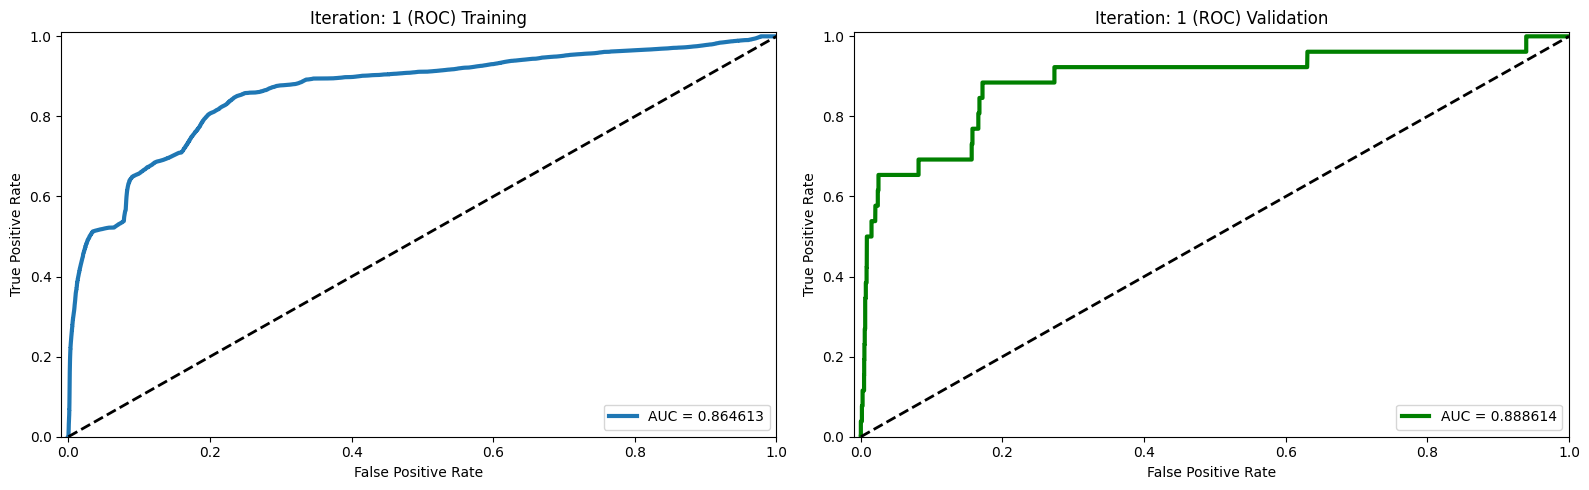

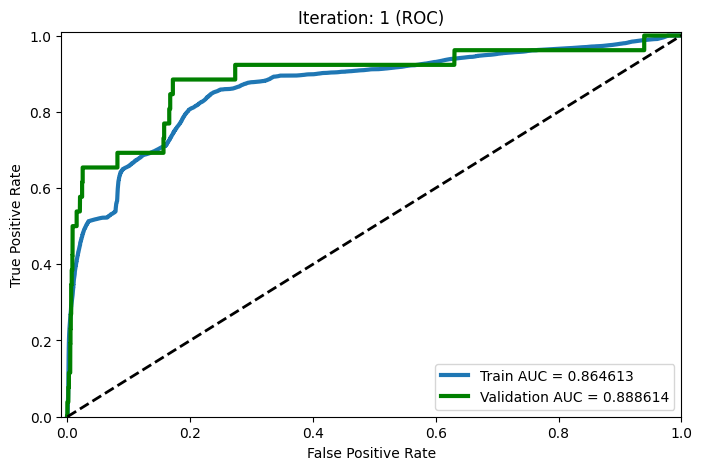

In [ ]:
from sklearn.metrics import auc

it = 1

# Retrieve ROC data for training
false_pos_rate = training_results[it]['false_pos_rate']
true_pos_rate = training_results[it]['true_pos_rate']
roc_auc = auc(false_pos_rate, true_pos_rate)

# Retrieve ROC data for testing (validation)
test_false_pos_rate = testing_results[it]['false_pos_rate']
test_true_pos_rate = testing_results[it]['true_pos_rate']
test_roc_auc = auc(test_false_pos_rate, test_true_pos_rate)

# Create subplots for side-by-side ROC comparison
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Plot ROC for training data
ax1.plot(false_pos_rate, true_pos_rate, linewidth=3, label='AUC = %f' % roc_auc)
ax1.plot([0, 1], [0, 1], 'k--', linewidth=2)  # Diagonal reference line

ax1.set_xlim([-0.01, 1])
ax1.set_ylim([0, 1.01])
ax1.legend(loc='lower right')
ax1.set_title(f'Iteration: {it} (ROC) Training')
ax1.set_ylabel('True Positive Rate')
ax1.set_xlabel('False Positive Rate')

# Plot ROC for test (validation) data
ax2.plot(test_false_pos_rate, test_true_pos_rate, linewidth=3, label='AUC = %f' % test_roc_auc, color='g')
ax2.plot([0, 1], [0, 1], 'k--', linewidth=2)  # Diagonal reference line

ax2.set_xlim([-0.01, 1])
ax2.set_ylim([0, 1.01])
ax2.legend(loc='lower right')
ax2.set_title(f'Iteration: {it} (ROC) Validation')
ax2.set_ylabel('True Positive Rate')
ax2.set_xlabel('False Positive Rate')

plt.tight_layout()
plt.show()

# Combined ROC plot for both training and validation on the same figure
plt.figure(figsize=(8, 5))
plt.plot(false_pos_rate, true_pos_rate, linewidth=3, label='Train AUC = %f' % roc_auc)
plt.plot(test_false_pos_rate, test_true_pos_rate, linewidth=3, label='Validation AUC = %f' % test_roc_auc, color='g')
plt.plot([0, 1], [0, 1], 'k--', linewidth=2)  # Diagonal reference line

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title(f'Iteration: {it} (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

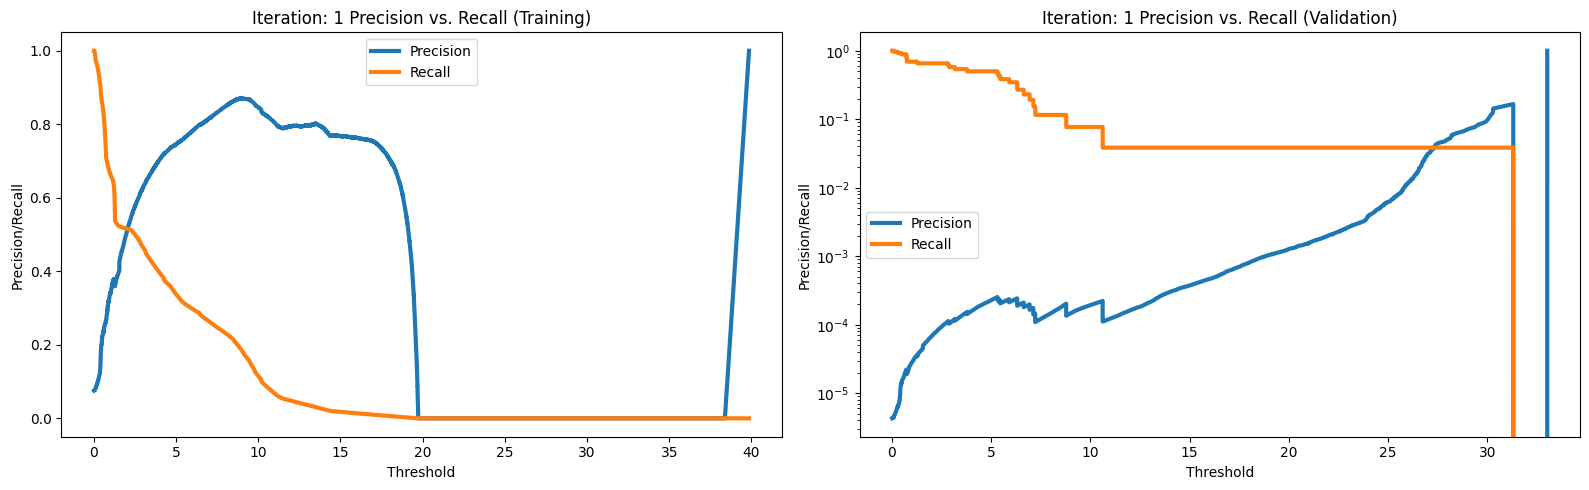

In [ ]:
precision_rt = training_results[it]['precision_rt']
recall_rt = training_results[it]['recall_rt']
threshold_rate = training_results[it]['threshold_rt']

# Create subplots for side-by-side comparison of training and validation
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Training Precision vs. Recall
ax1.plot(threshold_rate, precision_rt[1:], label="Precision", linewidth=3)
ax1.plot(threshold_rate, recall_rt[1:], label="Recall", linewidth=3)
ax1.legend()
ax1.set_title('Iteration: ' + str(it) + ' Precision vs. Recall (Training)')
ax1.set_ylabel('Precision/Recall')
ax1.set_xlabel('Threshold')

# Validation Precision vs. Recall
precision_rt = testing_results[it]['precision_rt']
recall_rt = testing_results[it]['recall_rt']
threshold_rate = testing_results[it]['threshold_rt']
ax2.plot(threshold_rate, precision_rt[1:], label="Precision", linewidth=3)
ax2.plot(threshold_rate, recall_rt[1:], label="Recall", linewidth=3)
ax2.legend()
ax2.set_yscale('log')  # Log scale for better visualization in validation
ax2.set_title('Iteration: ' + str(it) + ' Precision vs. Recall (Validation)')
ax2.set_ylabel('Precision/Recall')
ax2.set_xlabel('Threshold')

plt.tight_layout()
plt.show()

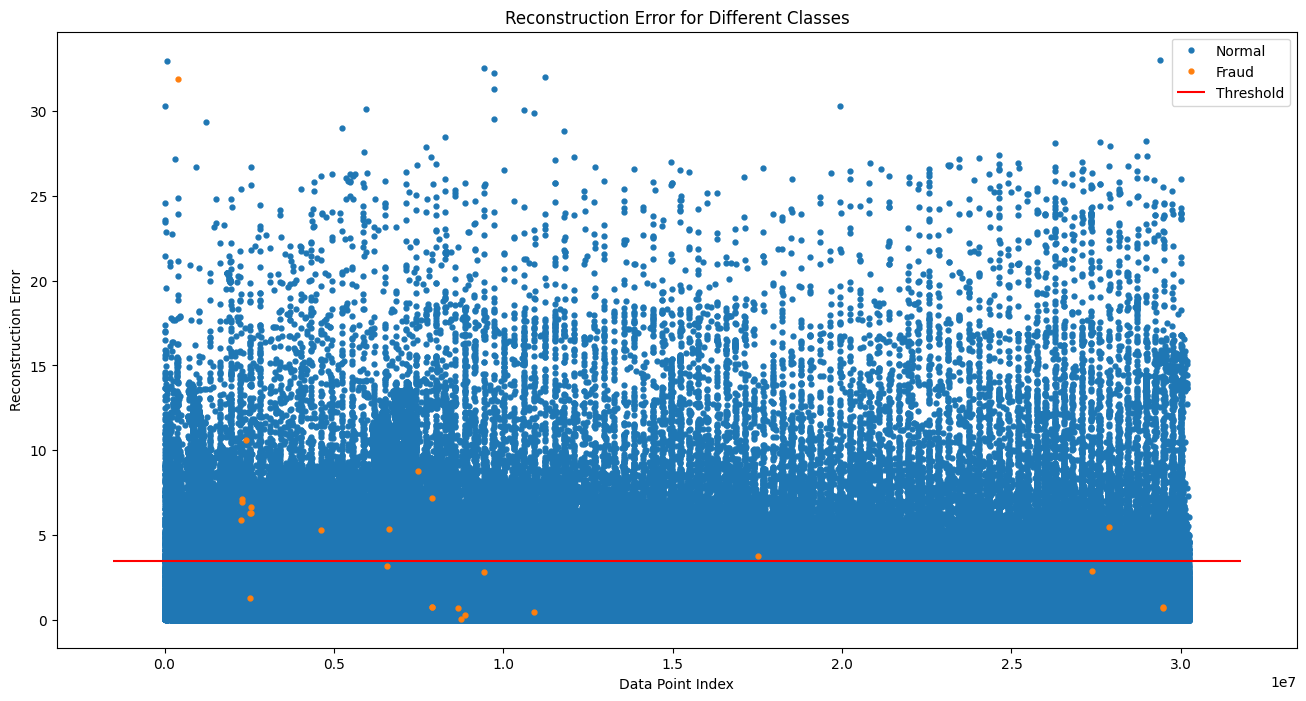

In [ ]:
test_threshold = 3.5

# Create DataFrames for the reconstruction errors and true class labels
test_error_df = pd.DataFrame({'Reconstruction_error': test_reconstruction_errors, 'True_class': y_test_full})
train_error_df = pd.DataFrame({'Reconstruction_error': reconstruction_errors, 'True_class': y_train_resampled})

# Group the test errors by their true class labels
groups = test_error_df.groupby('True_class')

# Create a plot for the reconstruction errors
fig, ax = plt.subplots(figsize=(16, 8))

for name, group in groups:
    ax.plot(list(group.index), group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label="Fraud" if name == 1 else "Normal")

# Add a horizontal line representing the threshold
ax.hlines(test_threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')

# Finalize the plot with labels, title, and legend
ax.legend()
plt.title("Reconstruction Error for Different Classes")
plt.ylabel("Reconstruction Error")
plt.xlabel("Data Point Index")
plt.show()

In [ ]:

def conf_matrix_percent(conf_matrix_train, conf_matrix_test):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    LABELS = ["Normal", "Fraud"]

    # Normalize the confusion matrix for training data
    conf_matrix_train_normalized = conf_matrix_train.astype('float') / conf_matrix_train.sum(axis=1)[:, np.newaxis]
    sns.heatmap(conf_matrix_train_normalized, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt=".0%", annot_kws={"size": 12}, ax=ax1)
    ax1.set_title("Training Confusion Matrix (Normalized)")
    ax1.set_ylabel('True Class')
    ax1.set_xlabel('Predicted Class')

    # Normalize the confusion matrix for test data
    conf_matrix_test_normalized = conf_matrix_test.astype('float') / conf_matrix_test.sum(axis=1)[:, np.newaxis]
    sns.heatmap(conf_matrix_test_normalized, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt=".0%", annot_kws={"size": 12}, ax=ax2)
    ax2.set_title("Test Confusion Matrix (Normalized)")
    ax2.set_ylabel('True Class')
    ax2.set_xlabel('Predicted Class')

    plt.show()

def conf_matrix_normal(conf_matrix_train, conf_matrix_test):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    LABELS = ["Normal", "Fraud"]

    # Plot the regular confusion matrix for training data
    sns.heatmap(conf_matrix_train, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", ax=ax1)
    ax1.set_title("Training Confusion Matrix")
    ax1.set_ylabel('True Class')
    ax1.set_xlabel('Predicted Class')

    # Plot the regular confusion matrix for test data
    sns.heatmap(conf_matrix_test, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", ax=ax2)
    ax2.set_title("Test Confusion Matrix")
    ax2.set_ylabel('True Class')
    ax2.set_xlabel('Predicted Class')

    plt.show()

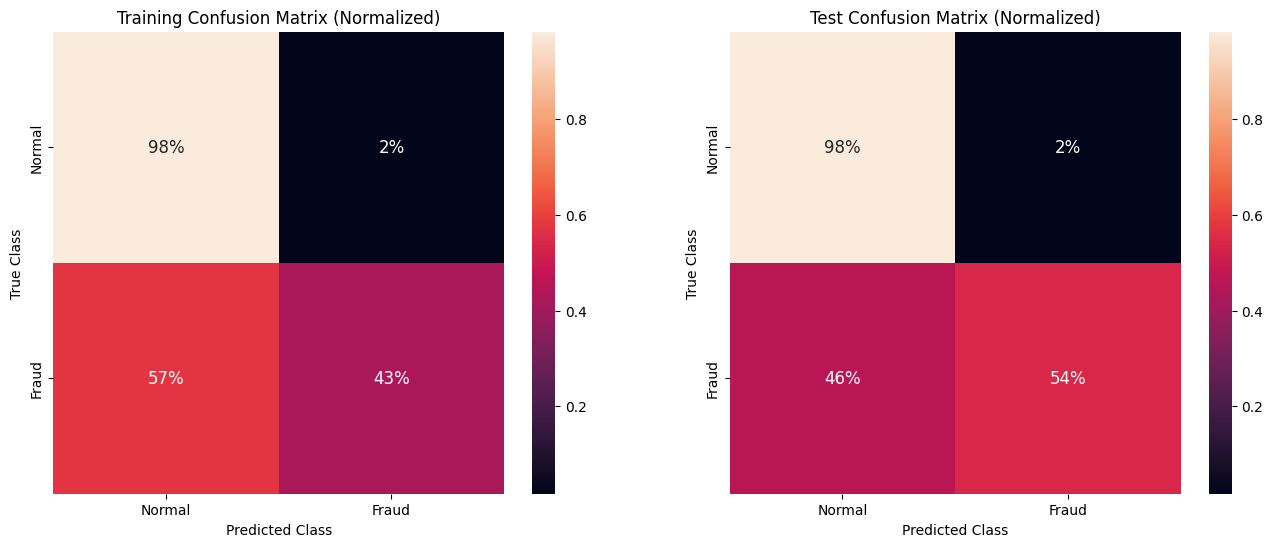

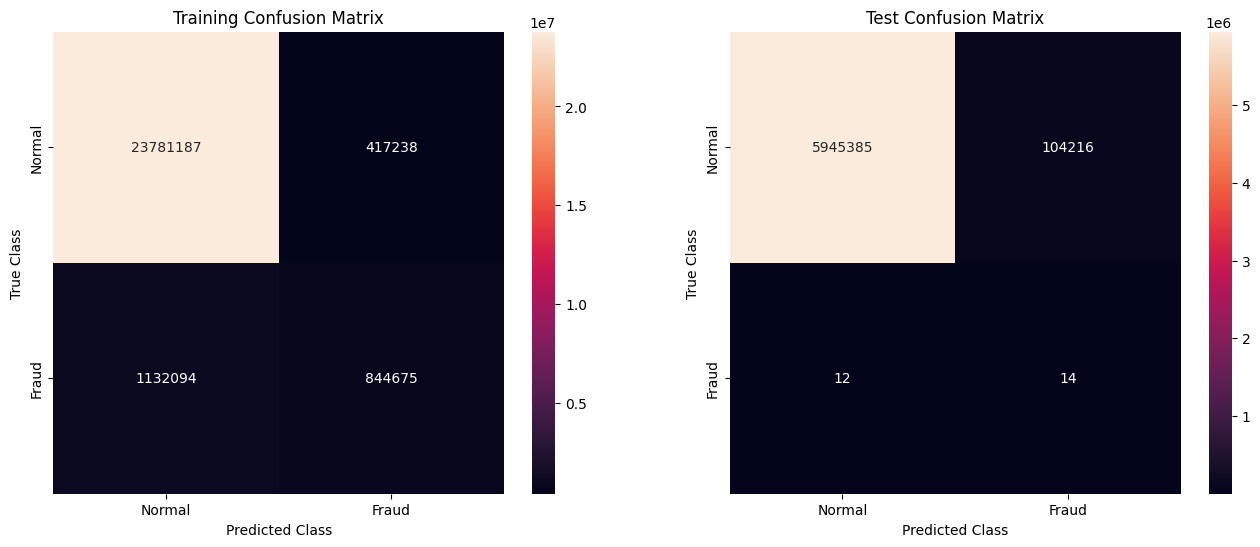

In [ ]:
# Generate predictions using the threshold
test_pred_y = [1 if e > test_threshold else 0 for e in test_error_df.Reconstruction_error.values]
train_pred_y = [1 if e > test_threshold else 0 for e in train_error_df.Reconstruction_error.values]

# Compute confusion matrices for both training and test sets
cnf_mtx_test = confusion_matrix(test_error_df.True_class, test_pred_y)
cnf_mtx_train = confusion_matrix(train_error_df.True_class, train_pred_y)

# Plot normalized confusion matrices
conf_matrix_percent(cnf_mtx_train, cnf_mtx_test)

# Plot regular confusion matrices
conf_matrix_normal(cnf_mtx_train, cnf_mtx_test)


Understanding the Confusion Matrix Elements
True Negative (TN):
The number of actual normal transactions correctly classified as normal.
Found in the top-left cell of the matrix.
False Positive (FP):
The number of normal transactions incorrectly classified as fraud.
Found in the top-right cell.
False Negative (FN):
The number of fraud transactions incorrectly classified as normal.
Found in the bottom-left cell.
True Positive (TP):
The number of fraud transactions correctly classified as fraud.
Found in the bottom-right cell.

Summary: Anomaly Detection in Blockchain Transactions Using Autoencoder
This project aims to detect fraudulent activities in blockchain transactions by leveraging an autoencoder model. The dataset contains historical transaction-level features such as transaction indegree, outdegree, total Bitcoins transferred, and anomaly labels (normal vs. fraudulent).

Key Objectives:
Identify anomalies in transaction patterns.
Use reconstruction errors from an autoencoder to flag suspicious transactions.
Methodology Overview
Data Preprocessing:

Log transformation and robust scaling were applied to normalize skewed transaction features.
Used SMOTE (Synthetic Minority Over-sampling Technique) to handle class imbalance, increasing the proportion of fraudulent samples for better training.
Autoencoder Model Architecture:

Encoder-Decoder Structure: The model consists of sequential layers for compressing input data and then reconstructing it.
Activation Functions: Tanh was used in hidden layers, with a final Sigmoid layer to ensure outputs are between 0 and 1.
Loss Function: Mean Squared Error (MSE) is used to measure reconstruction quality.
Model Training & Evaluation:

Trained on GPU for 100 epochs with a batch size of 256 to optimize the reconstruction error.
Evaluated using metrics like accuracy, precision, recall, F1-score, and ROC-AUC.
Anomalies were identified based on reconstruction errors, with a high ROC-AUC score indicating effective detection of fraudulent transactions.
Results:

The autoencoder effectively identified anomalies, achieving a clear separation between normal and fraudulent transactions.
ROC curves demonstrated strong performance in both training and validation phases.
Technologies Used
Python: Primary language for data preprocessing, model development, and evaluation.
PyTorch: Deep learning library used to build and train the autoencoder, leveraging GPU capabilities.
Modules Used: nn.Module, nn.Linear, nn.Tanh, and nn.Sigmoid for model layers; optim.Adam for optimization.
SMOTE (from imbalanced-learn): Addressed class imbalance by oversampling minority classes.
Scikit-learn: Used for data preprocessing (scaling, train-test split), evaluation metrics, and ROC-AUC calculations.
Matplotlib & Seaborn: For visualizing ROC curves, reconstruction errors, and other model performance metrics.
Google Colab: Cloud-based platform used for running experiments with GPU support, enabling faster model training.

In [1]:
model = load_model('/content/drive/MyDrive/BlockChainAnomaly/EthereumOriginal_model.h5')

NameError: name 'load_model' is not defined